In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow import keras
from tensorflow.keras import layers
#from kerastuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split

import efficientnet.tfkeras as efn
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
import os
from tensorflow.keras.backend import clear_session
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#import optuna

In [6]:

!pip install -q efficientnet

     |████████████████████████████████| 51kB 7.8MB/s 


In [12]:
train_dir = '/content/drive/MyDrive/Hackathon/medhack/gaussian_filtered_images/gaussian_filtered_images/'

In [13]:
datagen = ImageDataGenerator(rescale=1./255,
                                      zoom_range=0.2,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      validation_split=0.2
                                      )
train_data = datagen.flow_from_directory(train_dir,
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'training')

valid_data = datagen.flow_from_directory( train_dir,
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [14]:
for i in os.listdir(train_dir):
  a = os.listdir(train_dir+i)
  print(i, len(a))

Mild 370
Severe 193
Moderate 999
Proliferate_DR 295
No_DR 1805


Text(0, 0.5, 'Number of images')

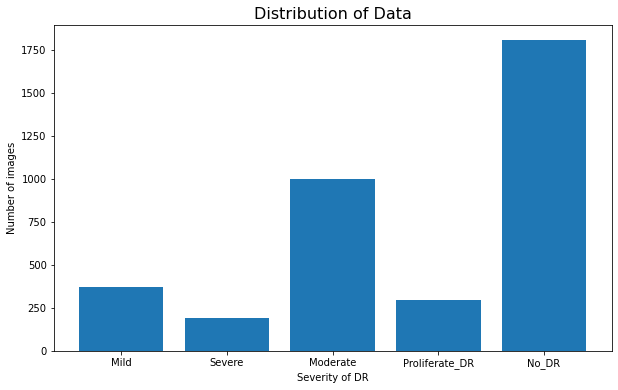

In [15]:
labels = ['Mild', 'Severe', 'Moderate', 'Proliferate_DR', 'No_DR']
values = [370, 193, 999, 295, 1805]

plt.figure(figsize=(10,6))
plt.bar(labels, values)
plt.title('Distribution of Data', fontdict={'fontsize':16})
plt.xlabel('Severity of DR')
plt.ylabel('Number of images')

In [17]:
plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, startangle=90, autopct=lambda p : '{:.2f}%'.format(p));
plt.title('Proportion of classes in data', fontdict={'fontsize':16})

NameError: ignored

<Figure size 432x432 with 0 Axes>

In [18]:
train_fnames = os.listdir( train_dir+'Mild' )
import matplotlib.pyplot as plt

In [19]:
image = plt.imread(train_dir + 'Mild/' + train_fnames[0])

In [20]:
a.shape

(224, 224, 3)

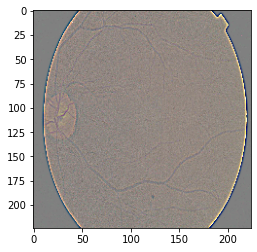

In [21]:
plt.imshow(image)

In [22]:
print(train_fnames)


['0024cdab0c1e.png', '00cb6555d108.png', '0124dffecf29.png', '0369f3efe69b.png', '01b3aed3ed4c.png', '03e25101e8e8.png', '04ac765f91a1.png', '059bc89df7f4.png', '05a5183c92d0.png', '0684311afdfc.png', '07929d32b5b3.png', '06b71823f9cd.png', '07a1c7073982.png', '086d41d17da8.png', '09935d72892b.png', '0ad7f631dedb.png', '0a61bddab956.png', '0a3202889f4d.png', '0d310aba6373.png', '0dc031c94225.png', '0dce95217626.png', '0f495d87656a.png', '0eb52045349f.png', '0fb1053285cf.png', '101b9ebfc720.png', '107aea0d9289.png', '10f36b0239fb.png', '12ce6a1a1f31.png', '1116271db4ea.png', '111898ab463d.png', '12e3f5f2cb17.png', '13ab8db8c700.png', '15cc2aef772a.png', '172df1330a60.png', '18b06f56ab27.png', '194814669fee.png', '17eff993386f.png', '19e350c7c83c.png', '1a03a7970337.png', '19722bff5a09.png', '1bb0ddfe753a.png', '1b329a127307.png', '1c0cf251b426.png', '1c3a6b4449e9.png', '1d11794057ff.png', '1df3e03a8f5f.png', '1d674e2e32e0.png', '200d947f75db.png', '22098b1fe461.png', '1e8a1fdee5b9.png',

In [23]:
#os.removedirs(train_dir+'/.ipynb_checkpoints')

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)

In [25]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.001
        return lr
    elif epoch<=15:
        lr=0.005
        return lr
    elif epoch<=30:
        lr=0.0001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [26]:
model = tf.keras.Sequential([
        efn.EfficientNetB0(
            input_shape=(224,224, 3),
            weights='imagenet',
            include_top=False
        ),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        #tf.keras.layers.BatchNormalization((2,2)),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        #tf.keras.layers.BatchNormalization((2,2)),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        #tf.keras.layers.BatchNormalization((2,2)),
        #tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['acc'])

16809984/16804768 [==============================] - 0s 0us/step


In [27]:
history=model.fit(train_data,validation_data = valid_data,callbacks=[lr_callback, callback],epochs=30,verbose=1)

Epoch 1/30
92/92 [==============================] - 1115s 12s/step - loss: 1.4276 - acc: 0.4394 - val_loss: 1.2272 - val_acc: 0.5746
Epoch 2/30
92/92 [==============================] - 54s 583ms/step - loss: 1.2210 - acc: 0.5434 - val_loss: 1.1064 - val_acc: 0.5964
Epoch 3/30
92/92 [==============================] - 54s 590ms/step - loss: 1.0955 - acc: 0.6045 - val_loss: 1.0414 - val_acc: 0.6389
Epoch 4/30
92/92 [==============================] - 54s 586ms/step - loss: 1.1073 - acc: 0.5931 - val_loss: 0.9732 - val_acc: 0.6498
Epoch 5/30
92/92 [==============================] - 54s 588ms/step - loss: 1.0033 - acc: 0.6340 - val_loss: 0.9277 - val_acc: 0.6662
Epoch 6/30
92/92 [==============================] - 54s 588ms/step - loss: 0.9942 - acc: 0.6539 - val_loss: 0.8731 - val_acc: 0.6785
Epoch 7/30
92/92 [==============================] - 54s 588ms/step - loss: 0.9809 - acc: 0.6446 - val_loss: 0.8555 - val_acc: 0.6922
Epoch 8/30
92/92 [==============================] - 54s 587ms/step - 

In [40]:
def display_training_curves(training, validation, title, subplot):
    
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('EfficientNet '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

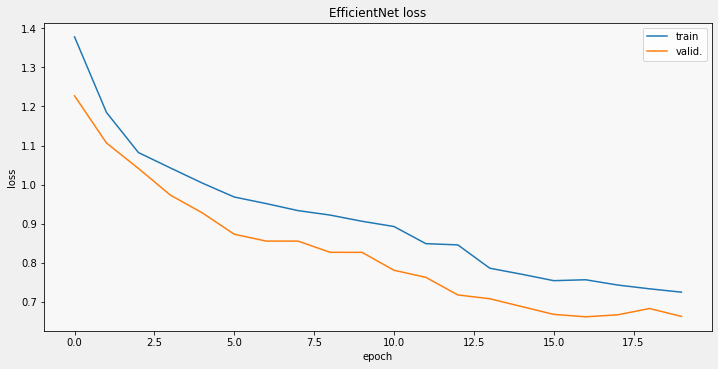

In [41]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss', 211)


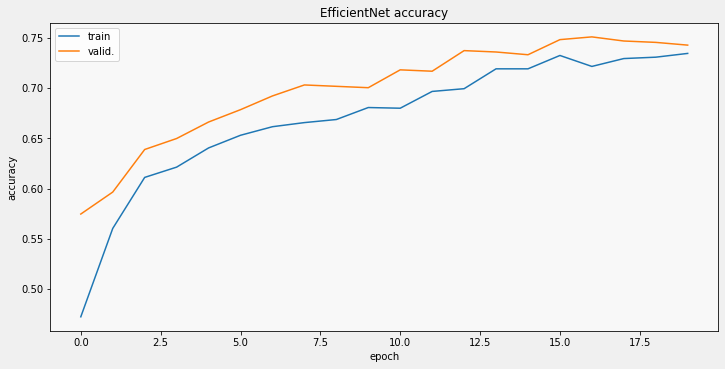

In [42]:
display_training_curves(
    history.history['acc'], 
    history.history['val_acc'], 
    'accuracy', 211)

In [39]:
model.save("/content/drive/MyDrive/Hackathon/medhack/model")
print("Saved model to disk")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Hackathon/medhack/model/assets
Saved model to disk


In [ ]:
#model.save() or tf.keras.models.save_model()

In [29]:
loaded = tf.keras.models.load_model("model")

In [30]:
loaded

In [146]:
['Mild', 'Severe', 'Moderate', 'Proliferate_DR', 'No_DR']

['Mild', 'Severe', 'Moderate', 'Proliferate_DR', 'No_DR']

In [161]:
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 path='/content/' + fn
  # predicting images
def predict_class(path)
  
  img=image.load_img(path, target_size=(224, 224))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  class = ''
  for idx, i in enumerate(classes.squeeze()):
    if i == 1.0:
      predicted_class += labels[idx]
      #print(classes)


  return predicted_class
  
  
  

Saving dr2.jfif to dr2 (12).jfif
2 1.0
Moderate


In [31]:
pip install -q pyyaml h5py

In [32]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.4.1


In [35]:
# Save the entire model as a SavedModel.
#!mkdir -p saved_model
loaded.save('model.h5')

In [36]:
new_model = tf.keras.models.load_model('model.h5')

In [38]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               32113152  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2